# Learn to Score a Tic-Tac-Toe Board by Example

## Introduction 


We want to use machine learning to support intelligent agents playing Tic-Tac-Toe (see [rules](https://en.wikipedia.org/wiki/Tic-tac-toe)). Here is the approach:

1. Simulate playouts to create labeled training data. The data $X$ is the board and the label $y$ indicates if the game resulted in a win or a loss.
2. Learn a model to predict the probability that we will win a given board. More specifically, we will learn here a function that predicts a score normalzed to a probability of a win for each board (i.e., $\hat{P}(y = \mathrm{win} | x) = h(x)$).
3. The model can be applied as:
   - the heuristic evaluation function for Heuristic Minimax Search.
   - a playout policy for better simulated games used in Pure Monte Carlo Search/Monte Carlo Tree Search.
   - self-play where we learn a model, use the model as the playout policy to create more a realistic training data for a better model. We keep on doing that as long as the model improves. 

## The board

I represent the board as a vector of length 9. The values are `' ', 'x', 'o'`.  

In [560]:
%precision 3

import numpy as np
import pandas as pd
import math

In [2]:
def empty_board():
    return [' '] * 9

board = empty_board()
display(board)

[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']

Some helper functions.


Add some x's and o's


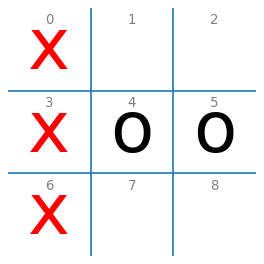

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def show_board(board, help = True, dpi = 40, colors = {' ': 'white', 'x': 'red', 'o': 'black'}):
    """Show the tic-tac-toe-board. help adds the array index, dpi changes the sice and 
    colors sets the colors"""
    
    b = np.array(board).reshape((3,3))

    with plt.rc_context({'figure.dpi': dpi}):
        fig = plt.matshow(np.zeros((3, 3)), cmap = ListedColormap(['w']))
    fig.axes.axis('off')
    
    plt.hlines([.5, 1.5], -.5, 2.5)
    plt.vlines([.5, 1.5], -.5, 2.5)

    for row in range(3):
        for col in range(3):
            plt.text(row, col, b[col, row], 
                 fontsize = 64, 
                 color = colors[b[col, row]],
                 horizontalalignment = 'center',
                 verticalalignment = 'center')
        
    if help:
        for row in range(3):
            for col in range(3):
                plt.text(col, row - .35, col + 3 * row, 
                     fontsize = 12, 
                     color = 'gray',
                     horizontalalignment = 'center',
                     verticalalignment = 'center')
        
        
    plt.show()
    
print()
print("Add some x's and o's")
board[0] = 'x'; board[3] = 'x'; board[6] = 'x';  board[4] = 'o'; board[5] = 'o' 
show_board(board)

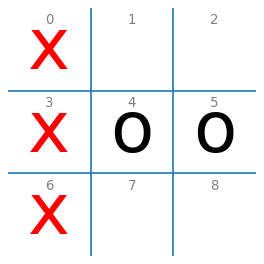

Win? x



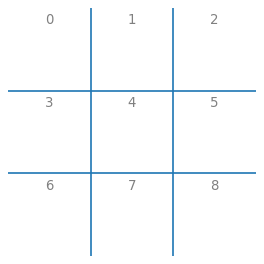

Win? n


In [4]:
def check_win(board):
    """check the board and return one of x, o, d (draw), or n (for next move)"""
    
    board = np.array(board).reshape((3,3))
    
    diagonals = np.array([[board[i][i] for i in range(len(board))], 
                          [board[i][len(board)-i-1] for i in range(len(board))]])
    
    for a_board in [board, np.transpose(board), diagonals]:
        for row in a_board:
            if len(set(row)) == 1 and row[0] != ' ':
                return row[0]
    
    # check for draw
    if(np.sum(board == ' ') < 1):
        return 'd'
    
    return 'n'

show_board(board)
print('Win? ' + check_win(board))

print()
show_board(empty_board())
print('Win? ' + check_win(empty_board()))

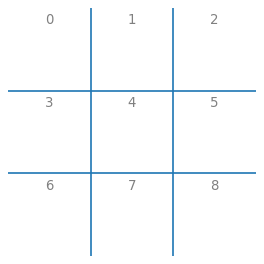


State for placing an x at position 4:


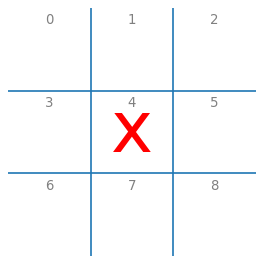

In [5]:
def result(state, player, action):
    """Add move to the board."""
    
    # copy state first because Python passes objects by reference
    state = state.copy()
    state[action] = player
    return state

show_board(empty_board())

print()
print("State for placing an x at position 4:")
show_board(result(empty_board(), 'x', 4))

In [6]:
def other(player): 
    """Switch players"""
    if player == 'x': return 'o'
    else: return 'x'

In [7]:
def utility(state, player = 'x'):
    """check is a state is terminal and return the utility if it is. None means not a terminal mode."""
    goal = check_win(state)        
    if goal == player: return +1 
    if goal == 'd': return 0  
    if goal == other(player): return -1  # loss is failure
    return None # continue

print(utility(['x'] * 9))
print(utility(['o'] * 9))
print(utility(empty_board()))

1
-1
None


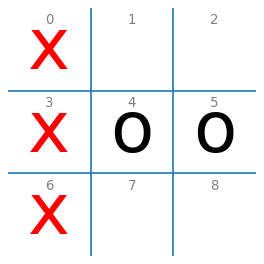

[1, 2, 7, 8]

In [8]:
def get_actions(board):
    """return possible actions as a vector ot indices"""
    return np.where(np.array(board) == ' ')[0].tolist()

    # randomize the action order
    #actions = np.where(np.array(board) == ' ')[0]
    #np.random.shuffle(actions)
    #return actions.tolist()
    
show_board(board)
get_actions(board)

# Create Training Data using Playouts

We will try to learn a function $\hat{y} = h(x)$ where $x$ is a board and $y$ is the estimated utility. The data we need to learn this model can be creating by running playouts (complete games) and recording the boards and mark them as leading to a win, loss or draw. Note: I learn a model that is specific to a player by using only the boards resulting from a move of that player.  

To describe $x$ for the learning algorithm, I translate empty cells to 0, `x` to 1 and `o` to -1. For $y$ I use the utility defined for win (1), loss (-1), and tie (0).

We will start with a **randomized playout policy.**

In [30]:
def playout_policy_random(state = None, player = 'x', get_model = False, *args, **kwargs):
    """A policy funciton returns for a state an action."""
    if get_model:
        return None
    return np.random.choice(get_actions(state))

playout_policy_random(board)

2

Player x:


'X_x:'

[[0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 1, 0, -1, 0, 1],
 [0, 0, 0, -1, 1, 0, -1, 1, 1],
 [0, 0, -1, -1, 1, 1, -1, 1, 1]]

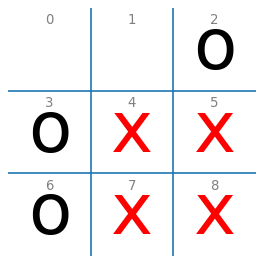

'y_x:'

[-1, -1, -1, -1]


Player o:


'X_o:'

[[0, 0, 0, 0, 0, 0, -1, 0, 1],
 [0, 0, 0, -1, 1, 0, -1, 0, 1],
 [0, 0, -1, -1, 1, 0, -1, 1, 1],
 [-1, 0, -1, -1, 1, 1, -1, 1, 1]]

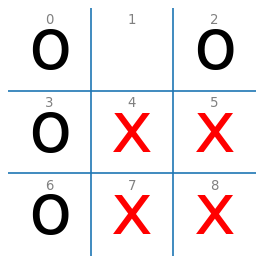

'y_o:'

[-1, -1, -1, -1]

In [549]:
tr = {' ': 0, 'x': 1, 'o': -1} # I translate the board into numbers
tr2 = {'0': ' ', '1' : 'x', '-1' : 'o'} # I translate the board into numbers

def encode_state(state):
    """Represent the board as a vector of numbers suitable for training
    a classifier."""
    return [tr[s] for s in state]

def decode_state(state):
    return [tr2[str(s)] for s in state]

def playout(state = empty_board(), next_player = 'x',
                   playout_policy = { 
                       'x' : playout_policy_random, 
                       'o' : playout_policy_random} 
                  ):
    """Run a playout and record the boards after each player's move."""
    
    current_player = next_player
    boards = { 'x' : [], 'o' : [] }
    
    while(True):
        # reached terminal state?
        u = utility(state, 'x')
        if u is not None: 
            return(
                boards['x'], [u] * len(boards['x']),
                boards['o'], [u] * len(boards['o'])
            )                                     
  
        a = playout_policy[current_player](state)
        state = result(state, current_player, a)   
  
        boards[current_player].append(encode_state(state))

        # switch between players
        current_player = other(current_player)

X_x, y_x, X_o, y_o = playout()

print("Player x:")
display('X_x:', X_x)
show_board(decode_state(X_x[-1]))
display('y_x:', y_x)

print("\nPlayer o:")
display('X_o:', X_o)
show_board(decode_state(X_o[-1]))
display('y_o:', y_o)

Run `N` playouts and create a pandas dataframe for `X` and a numpy array for `y`. These data structures work for `sklearn`. 

In [550]:
def create_data(N = 100, 
                playout_policy = { 
                    'x' : playout_policy_random, 
                    'o' : playout_policy_random}):
    board_x = []
    utility_x = []
    board_o = []
    utility_o = []
    
    for i in range(N):
        b_x, u_x, b_o, u_o = playout(playout_policy = playout_policy)
        board_x.extend(b_x)
        utility_x.extend(u_x)
        board_o.extend(b_o)
        utility_o.extend(u_o)
        
    return [pd.DataFrame(board_x), np.array(utility_x),
           pd.DataFrame(board_o), np.array(utility_o)]
        
X_x, y_x, X_o, y_o = create_data(N = 2)

print("X_x:")
display(X_x)

print("y_x:")
display(y_x)

print("X_o:")
display(X_o)

print("y_o:")
display(y_o)

X_x:


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,1,-1,0,0
2,1,0,-1,1,0,1,-1,0,0
3,1,-1,-1,1,0,1,-1,1,0
4,1,-1,-1,1,1,1,-1,1,-1
5,0,0,0,0,1,0,0,0,0
6,0,1,0,0,1,-1,0,0,0
7,0,1,0,0,1,-1,0,1,-1


y_x:


array([1, 1, 1, 1, 1, 1, 1, 1])

X_o:


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,1,-1,0,0
1,1,0,-1,0,0,1,-1,0,0
2,1,-1,-1,1,0,1,-1,0,0
3,1,-1,-1,1,0,1,-1,1,-1
4,0,0,0,0,1,-1,0,0,0
5,0,1,0,0,1,-1,0,0,-1


y_o:


array([1, 1, 1, 1, 1, 1])

In [ ]:
Play some real games and report the results.

In [551]:
from collections import Counter

def play(N = 100, playout_policy = { 
                    'x' : playout_policy_random, 
                    'o' : playout_policy_random}):
    
    wins = []
    
    for i in range(N):
        b_x, u_x, b_o, u_o = playout(playout_policy=playout_policy)
        wins.append(u_x[0])
        
    cnts = Counter(wins)
    cnts = { 'x': cnts[1]/N, 'o': cnts[-1]/N, 'draws' : cnts[0]/N }
    return cnts

play()

{'x': 0.500, 'o': 0.340, 'draws': 0.160}

## Learn a Playout Policy

We learn an Artificial Neural Network (ANN) to approximate $y = f(X)$ by $\hat{y} = h(X)$. See
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

ANNs are popular for this kind of task but other classification models can also be used (e.g., decision trees).

We need to learn a model for each player.

In [575]:
from sklearn.neural_network import MLPClassifier

def learn_policy(X, y, player = 'x', size = 100, max_iter = 200, 
                 old_policy = None):
    """returns a policy function. If old_policy is a mlp, then we use
    it to warmstart learning."""
    
    if (old_policy is None or old_policy(get_model = True) is None):
        clf = MLPClassifier(
            hidden_layer_sizes = (size),
            max_iter = max_iter,
            warm_start = False
        ) 
    else: 
        clf = old_policy(get_model = True)
    
    # add dummy boards to make sure all outcomes are represented for the classifier
    # this is dirty, but Python does not know any better
    X = X.append(
        pd.DataFrame(
            np.repeat(np.matrix(encode_state(empty_board())), [3], axis = 0)))
    y = np.append(y, [-1,0,1])
    
    clf.fit(X, y)
     
    def pol(state = None, 
            get_model = False, show_exp_utility=False):
        """use the policy for a state. 
        get_model = True returns the policy's model."""
        if get_model: 
            return(clf)

        def exp_utility(state, player, a):
            return np.sum(clf.predict_proba(pd.DataFrame([encode_state(result(state, player, a))])) * [-1, 0 , 1])
        
        values = { a : exp_utility(state, player, a) for a in get_actions(state) }
        
        if (show_exp_utility):
            print("Actions and expected utility:", values)

        # choose action proportional to the utility.
        p = list(values.values())
        p = np.array(p)
        
        if player == 'x':
            p = p + 1
        else:
            p = -1 * p + 1
        
        p = p ** 2
        if p.sum() == 0:
            p = np.array([1] * len(p))
        
        p = p / p.sum() 
            
        actions = [int(k) for k in values.keys()]
        
        action = (np.random.choice(actions, p = p))  
        return action
    
    return pol

In [576]:
X_x, y_x, X_o, y_o = create_data(1000)
playout_policy_x = learn_policy(X_x, y_x, player ="x", max_iter=1000)
playout_policy_o = learn_policy(X_o, y_o, player ="o", max_iter=1000)

## Some Tests

We evaluate some boards where `x` just made a move. The classifier tries to predict the most likely outcome
of the game as -1 = `o` wins, 0 = draw, and 1 = `x` wins. The classifier can also predict the probability of the three possible outcomes. We can use these probabilities as weights to calculate the expected utility in the range $[-1,1]$.

Board:


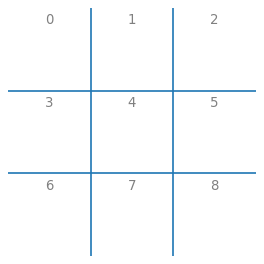

Actions and expected utility: {0: 0.2421747288140212, 1: 0.40752562807497783, 2: 0.3400693727407244, 3: 0.22516163146702528, 4: 0.34023471590251253, 5: 0.30880700958625673, 6: 0.170226122121111, 7: 0.5243888006564218, 8: 0.3033937050008901}


[2, 1, 4, 5, 2, 3, 8, 3, 6, 7, 1, 1, 2, 7, 2, 1, 1, 1, 4, 0]

In [582]:
# best first move

board = empty_board()

print("Board:")
show_board(board)

playout_policy_x(board, show_exp_utility = True)
[playout_policy_x(board) for i in range(20)]

Board:


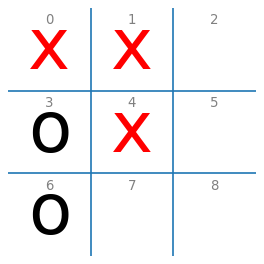

Actions and expected utility: {2: 0.9915418851617234, 5: 0.357717965027308, 7: 0.956228364849623, 8: 0.9148624776222044}


[8, 7, 7, 5, 8, 7, 8, 8, 2, 5, 7, 2, 8, 8, 5, 8, 2, 2, 2, 7]

In [581]:
# x will win

board = ['x', 'x', ' ',
         'o', 'x', ' ',
         'o', ' ', ' ']

print("Board:")
show_board(board)

playout_policy_x(board, show_exp_utility = True)
[playout_policy_x(board) for i in range(20)]

Board:


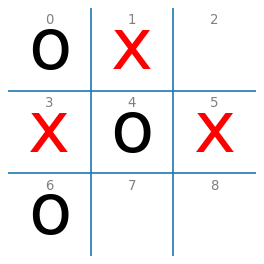

Actions and expected utility: {2: -0.01704469044045137, 7: -0.9529265053350287, 8: -0.5437884974579602}


[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2]

In [580]:
# x made a mistake and will lose.

board = ['o', 'x', ' ',
         'x', 'o', 'x',
         'o', ' ', ' ']
    
print("Board:")
show_board(board)

playout_policy_x(board, show_exp_utility = True)
[playout_policy_x(board) for i in range(20)]

Board:


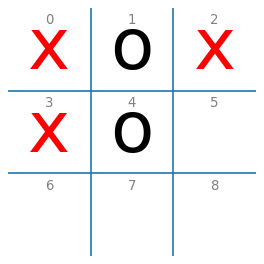

Actions and expected utility: {5: 0.6633516278199119, 6: 0.17529210028536124, 7: -0.650035714361397, 8: 0.4313177017924158}


[7, 8, 7, 6, 7, 7, 5, 7, 6, 7, 7, 7, 7, 7, 6, 7, 8, 7, 7, 7]

In [579]:
# It's o's turn and o will win

board = ['x', 'o', 'x',
         'x', 'o', ' ',
         ' ', ' ', ' ']

print("Board:")
show_board(board)

playout_policy_o(board, show_exp_utility = True)
[playout_policy_o(board) for i in range(20)]

In [566]:
print('random vs. random: ', play())

print('policy x vs. random: ', play(playout_policy = { 
                           'x' : playout_policy_x,                    
                           'o' : playout_policy_random}))  
print('random vs. policy o: ', play(playout_policy = { 
                           'x' : playout_policy_random,                    
                           'o' : playout_policy_o}))  
    

random vs. random:  {'x': 0.51, 'o': 0.36, 'draws': 0.13}
policy x vs. random:  {'x': 0.76, 'o': 0.14, 'draws': 0.1}
random vs. policy o:  {'x': 0.25, 'o': 0.64, 'draws': 0.11}


# Selfplay

x and o play in each round 100 games with the current playout policy and then they use the played games to learn a new playout policy to play better in the next round.

In [578]:
from collections import Counter

N = 500

print("\nRandom baseline policy:")
playout_policy_x = playout_policy_random
playout_policy_o = playout_policy_random
print('random vs random: ', play(playout_policy = { 
                           'x' : playout_policy_x,                    
                           'o' : playout_policy_o})) 

for i in range(20):
    print("\nSelfplay round", i + 1)
        
    X_x, y_x, X_o, y_o = create_data(N, 
                       playout_policy = { 
                           'x' : playout_policy_x,                    
                           'o' : playout_policy_o})
    
    playout_policy_x = learn_policy(X_x, y_x, player ="x", 
                                    old_policy = playout_policy_x, max_iter=N)
    playout_policy_o = learn_policy(X_o, y_o, player ="o", 
                                    old_policy = playout_policy_o, max_iter=N)
    
    
    print('policy x vs. random: ', play(playout_policy = { 
                           'x' : playout_policy_x,                    
                           'o' : playout_policy_random}))  
    print('random vs. policy o: ', play(playout_policy = { 
                           'x' : playout_policy_random,                    
                           'o' : playout_policy_o}))  
    print('policy x vs policy o: ', play(playout_policy = { 
                           'x' : playout_policy_x,                    
                           'o' : playout_policy_o}))   
 
 


Random baseline policy:
policy x vs policy o:  {'x': 0.58, 'o': 0.26, 'draws': 0.16}

Selfplay round 1


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


policy x vs. random:  {'x': 0.68, 'o': 0.19, 'draws': 0.13}
random vs. policy o:  {'x': 0.26, 'o': 0.62, 'draws': 0.12}
policy x vs policy o:  {'x': 0.55, 'o': 0.34, 'draws': 0.11}

Selfplay round 2


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


policy x vs. random:  {'x': 0.76, 'o': 0.17, 'draws': 0.07}
random vs. policy o:  {'x': 0.41, 'o': 0.48, 'draws': 0.11}
policy x vs policy o:  {'x': 0.55, 'o': 0.28, 'draws': 0.17}

Selfplay round 3


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


policy x vs. random:  {'x': 0.73, 'o': 0.17, 'draws': 0.1}
random vs. policy o:  {'x': 0.35, 'o': 0.55, 'draws': 0.1}
policy x vs policy o:  {'x': 0.5, 'o': 0.4, 'draws': 0.1}

Selfplay round 4


KeyboardInterrupt: 

In [572]:
y_o

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,
        0,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1,
       -1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1,
        0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1,
        1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1,  1,  1,
        1,  1,  1,  1,  1, -1, -1, -1, -1,  0,  0,  0,  0,  1,  1,  1,  1,
       -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  0,  0,  0,  0,  1,  1,  1,  1,  1, -1, -1, -1,
       -1, -1, -1, -1, -1